# Ship Damage Probability
Should I roll the dice? This notebook provides the probabilities that will help Seafall players make that decision.

In [2]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import pandas
import scipy.misc
import scipy.special
import seaborn

## A cursed throw during the prologue
I went to explore a region on the first island, my flag ship being supported by the second ship in my fleet. With the Woodsman as my advisor I would have 4 dice to roll where I needed three successes to avoid damage to my ship. I cast my dice and recoiled once they settled on 3 blanks and merely 1 success. I felt this had to have been some rather unlucky outcome. Was I cursed?

## Counting the outcomes of dice rolls
Dice rolls can be [framed](http://math.stackexchange.com/questions/900672/how-many-combinations-from-rolling-5-identical-dice) as [stars and bars](http://math.stackexchange.com/questions/208377/combination-with-repetitions) problems. This is a clever way to frame the combinatorics of dice rolling. The combination formula is used to choose the location of the bars, whose position determines how many dice show a particular face. The stars between the bars represent the number of dice showing a particular face; the identity of that face is determined by how many bars are to the right (or left) of the star(s). If two bars are adjacent that means there aren't any dice showing that particular face.

The combination is very useful for counting outcomes, especially when considering only two possibilities. In Seafall, often it only matters whether to face of a die is blank or not. In these cases, the combination formula can be used to count the outcomes by counting the ways a pool of dice can be divided between the two possibilities. Note that the multinomial coefficient formula reduces to the combination formula for two possibilities; the multinomial formula comes into play in more complex situations encountered in Seafall. We'll be using [combinations](https://en.wikipedia.org/wiki/Combination) to do the heavy lifting of the calculations. 

In [4]:
# FWIW, total number of unique outcomes from rolling 4, 6-sided dice.
# Note that stars-and-bars is also called combination with repition.
print scipy.misc.comb(6, 4, repetition=True) # scipy.misc.comb(# of faces, # of dice, repitition=True)
# permutation
print scipy.special.perm(6,4)
# combination: asks, "Given 4 dice, how many combinations can be made by choosing 2 of the 4."
print scipy.misc.comb(6,4)

126.0
360.0
15.0


Since the possibilities of rolling a blank is weighted, i.e. the chance of rolling a blank does not equal the probability of *not* rolling a blank, counting the outcomes alone will not yield the correct probability. Each outcome for a given combination will however share the same probability, so it is only a matter of finding the probability for a single outcome and multiplying it by the total number of outcomes.

In [3]:
cursed_probability = (1.0/3)**3 * (2.0/3) * scipy.misc.comb(4,1) + (1.0/3)**4
print cursed_probability

0.111111111111


My roll would only happen 11% of the time, so I would consider myself unlucky and stop just short of calling myself cursed.

# A simulation
Before we explicitly calculate the probabilites for potential ship damage, simuating the dice rolls to sample the actual probability is a useful sanity check we can refer to as we code-up the exact probabilities.

In [5]:
p_blank = 1.0/3

def simulate_roll(total_dice):
    x = numpy.random.uniform(size=total_dice)
    conds = [x <= p_blank, (x > p_blank)]
    # each blank counts as 1, a major success counts as -1, and a regular success counts as 0
    roll_array = numpy.piecewise(x, conds, [1, 0])
    return numpy.sum(roll_array)

def blank_roll_simulator(total_dice, n):
    sim_list = [simulate_roll(total_dice) for i in range(n)]
    return numpy.array(sim_list)
    #return {"num_blank" : num_blank_array, "p_blank" : p_blank_array}
    
n = 100000
blank_count_list = [blank_roll_simulator(i, n) for i in numpy.arange(1,16)]
for i, array in enumerate(blank_count_list):
    array[array < 0] = 0
    blank_count_list[i] = array
blank_count_itemfreq = [scipy.stats.itemfreq(a) for a in blank_count_list]

sdo_sim = numpy.zeros((15,16))
for i, array in enumerate(blank_count_itemfreq):
    for j in array:
        sdo_sim[i, j[0].astype(int)] = j[1]/n
        
# for the greater than or equal probabilites, sum along the rows
sdo_sim_gte = numpy.zeros((15,15))

for (i, j), _ in numpy.ndenumerate(sdo_sim_gte):
    sdo_sim_gte[i, j] = numpy.sum(sdo_sim[i, j+1:])

row_blank = numpy.arange(1,16) # number of dice showing the blank face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdo_sim_gte_dataframe = pandas.DataFrame(data = sdo_sim_gte, index = row_blank, columns = col_dice)
sdo_sim_gte_dataframe_stack = sdo_sim_gte_dataframe.stack().reset_index().rename(columns = {"level_0" : "number_blank", "level_1" : "number_dice_pool", 0 : "probability_GTE_to_number_blank"})
sdo_sim_gte_mask = numpy.triu(numpy.ones((15,15)), 1)
sdo_sim_gte_pivot = sdo_sim_gte_dataframe_stack.pivot("number_blank", "number_dice_pool", "probability_GTE_to_number_blank")




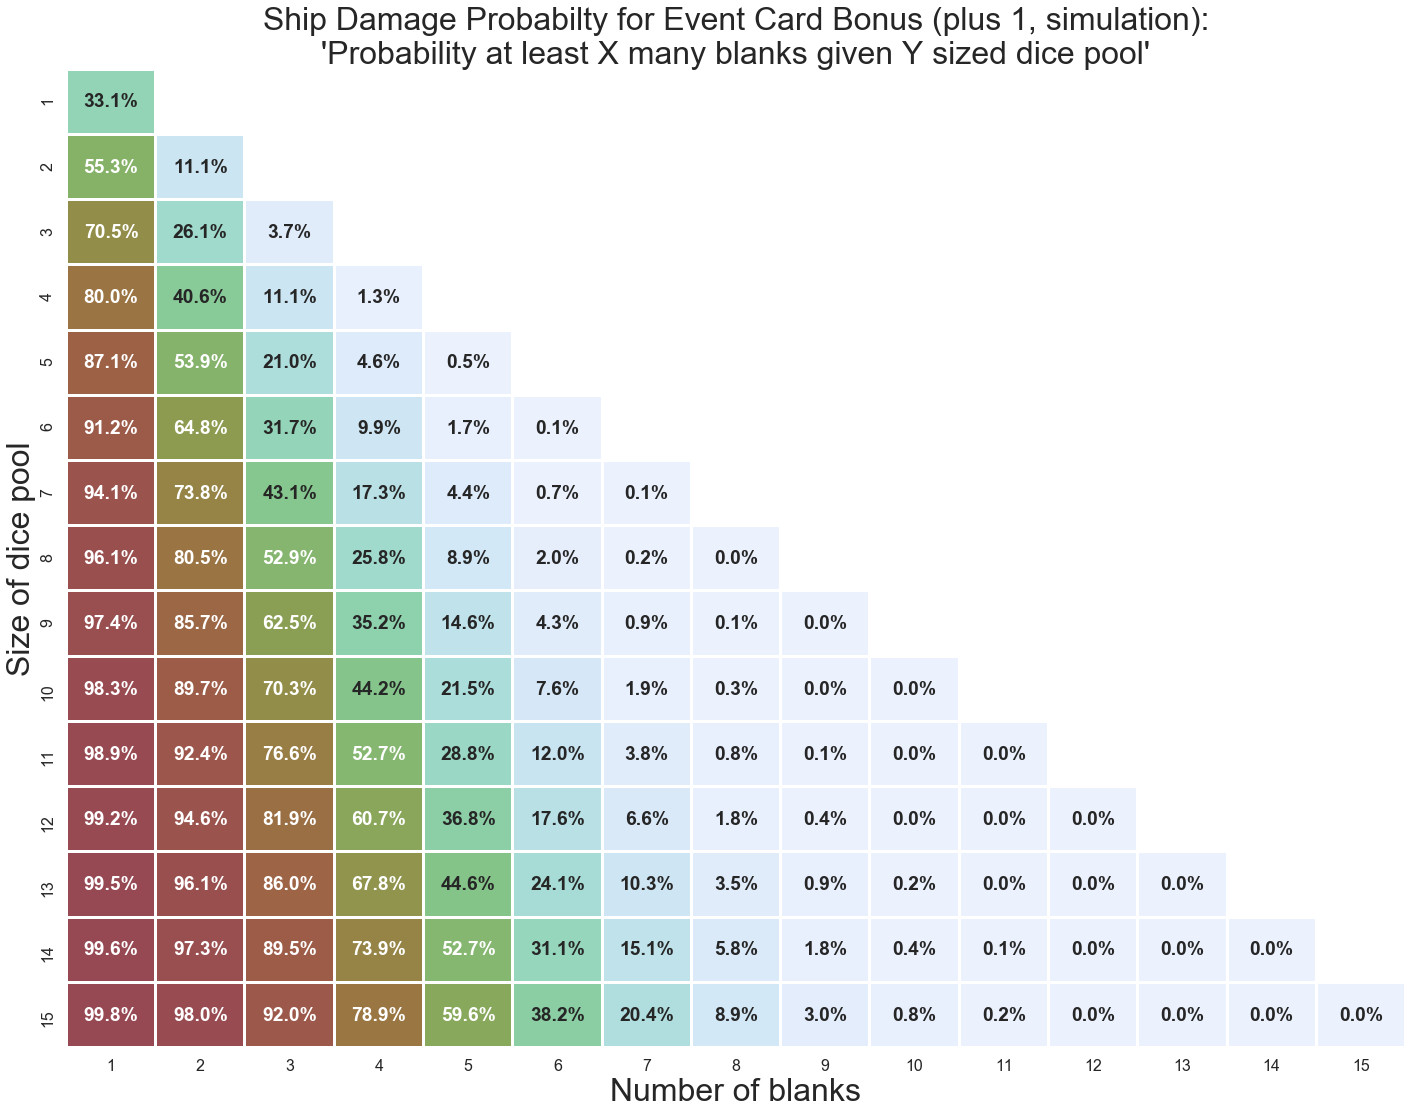

In [6]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
cmap = seaborn.cubehelix_palette(n_colors = 6,
                                start = 1.5,
                                rot = 1.5,
                                gamma = 1.5,
                                hue = 1.0,
                                dark = 0.525,
                                light = 0.96,
                                reverse = False,
                                as_cmap = True)
ax = seaborn.heatmap(sdo_sim_gte_pivot, 
                     annot = True, 
                     cmap = cmap,
                     cbar = False,
                     mask = sdo_sim_gte_mask,
                     annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", 
                     linewidths = 2,
                     vmin=0.0, 
                     vmax=1.0)

ax.set_title("Ship Damage Probabilty for Event Card Bonus (plus 1, simulation):\n'Probability at least X many blanks given Y sized dice pool'",
            fontsize=32)
ax.set_xlabel("Number of blanks", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)


fig = ax.get_figure()
fig.savefig("sdo_gte_sim_15.pdf")

In [4]:
p_blank = 1.0/3

def prob_blank(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        p = (p_blank)**num_blank * \
        (1.0-p_blank)**(total_dice-num_blank) * \
        scipy.misc.comb(total_dice, total_dice - num_blank)
    return p

In [5]:
cursed_probability = prob_blank(3,4) + prob_blank(4,4)
print cursed_probability

0.111111111111


In [6]:
def prob_blank_or_worse(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        rng_blank = numpy.arange(num_blank, total_dice + 1)
        array_blank = [prob_blank(n, total_dice) for n in rng_blank]
        p = numpy.sum(array_blank)
    return p

In [7]:
cursed_probability = prob_blank_or_worse(1,4)
print cursed_probability

0.802469135802


# SDO matrix
There are 15 custom dice within Seafall, so a matrix should be large enough to assess the situation where all 15 are rolled. Since the early game does not use near this many dice, several visualizations will be created.

In [8]:
row_blank = numpy.arange(1,16) # number of dice showing the blank face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdo = numpy.zeros((numpy.size(row_blank),numpy.size(col_dice)))
prob = [prob_blank_or_worse(*i) for i in itertools.product(row_blank, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_blank, col_dice)]
for idx, val in enumerate(ind):
    sdo[val] = prob[idx]

In [9]:
# http://stackoverflow.com/questions/41474284/how-to-convert-a-matrix-into-column-array-with-pandas-python
sdo_dataframe = pandas.DataFrame(data = sdo, index = row_blank, columns = col_dice)
sdo_dataframe_stack = sdo_dataframe.stack().reset_index().rename(columns = {"level_0" : "number_blank", "level_1" : "number_dice_pool", 0 : "probability_GTE_to_number_blank"})

In [10]:
sdo_dataframe_stack["mask"] = sdo_dataframe_stack["probability_GTE_to_number_blank"] == 0
sdo_mask = sdo_dataframe_stack.pivot("number_dice_pool", "number_blank", "mask").values

In [11]:
sdo_pivot = sdo_dataframe_stack.pivot("number_dice_pool", "number_blank", "probability_GTE_to_number_blank")

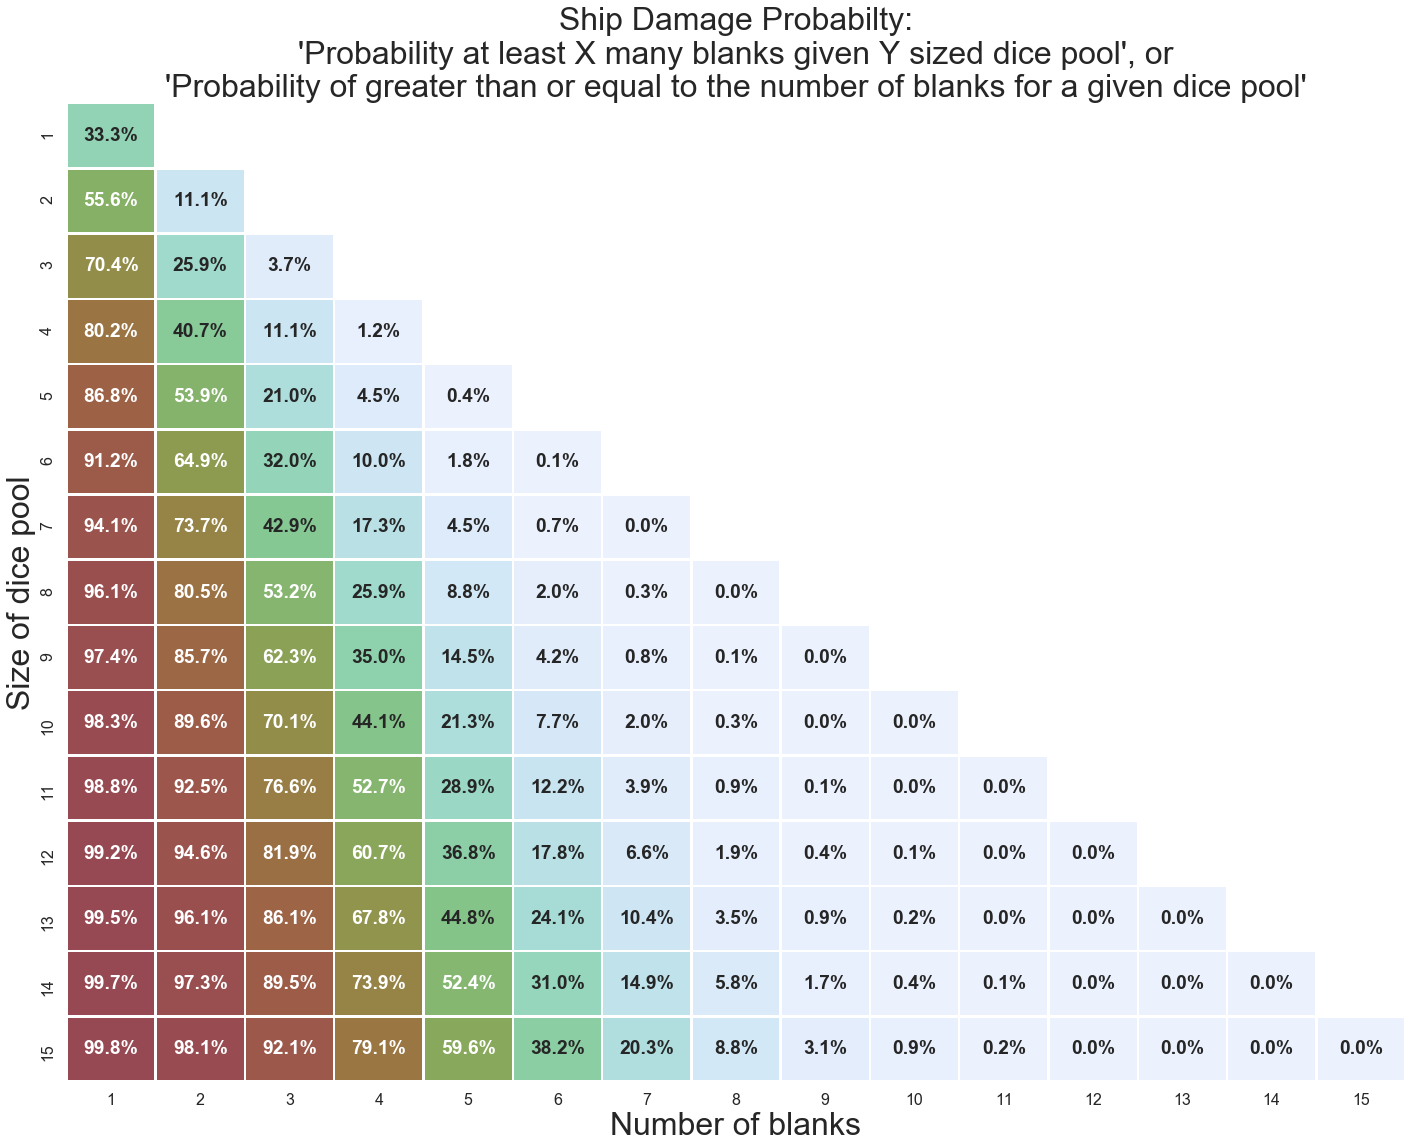

In [12]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
cmap = seaborn.cubehelix_palette(n_colors = 6,
                                start = 1.5,
                                rot = 1.5,
                                gamma = 1.5,
                                hue = 1.0,
                                dark = 0.525,
                                light = 0.96,
                                reverse = False,
                                as_cmap = True)
ax = seaborn.heatmap(sdo_pivot, 
                     annot = True, 
                     cmap = cmap,
                     cbar = False,
                     mask = sdo_mask,
                     annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", 
                     linewidths = 1.5,
                     vmin=0.0, 
                     vmax=1.0)

ax.set_title("Ship Damage Probabilty:\n'Probability at least X many blanks given Y sized dice pool', or\n'Probability of greater than or equal to the number of blanks for a given dice pool'",
            fontsize=32)
ax.set_xlabel("Number of blanks", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)


fig = ax.get_figure()
fig.savefig("sdo_15.pdf")

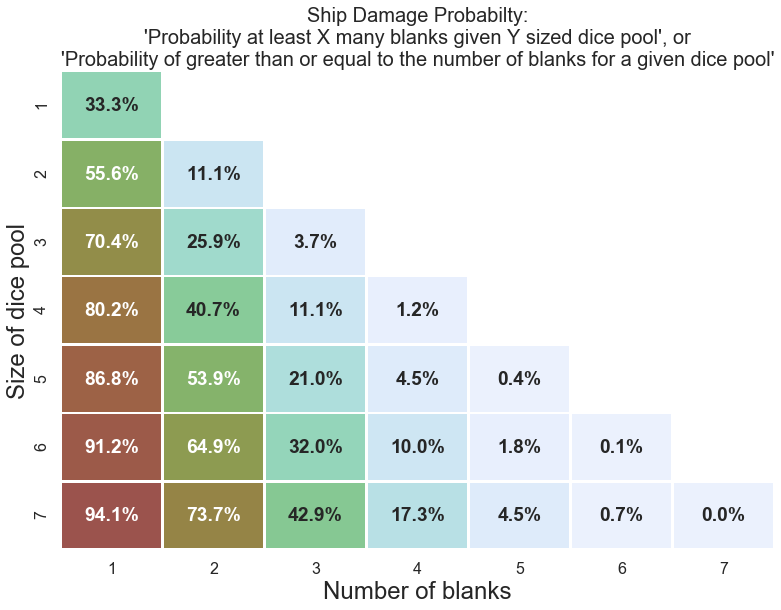

In [13]:
sdo_dataframe_7 = sdo_dataframe_stack.loc[(sdo_dataframe_stack["number_blank"] < 8) & (sdo_dataframe_stack["number_dice_pool"] < 8)]
sdo_mask_7 = numpy.triu(numpy.ones((7,7)), 1)
sdo_pivot_7 = sdo_dataframe_7.pivot("number_dice_pool", "number_blank", "probability_GTE_to_number_blank")

ax2 = seaborn.heatmap(sdo_pivot_7, 
                     annot = True, 
                     cmap = cmap,
                     cbar = False,
                     mask = sdo_mask_7,
                     annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", 
                     linewidths = 1.5,
                     vmin=0.0, 
                     vmax=1.0)

ax2.set_title("Ship Damage Probabilty:\n'Probability at least X many blanks given Y sized dice pool', or\n'Probability of greater than or equal to the number of blanks for a given dice pool'",
            fontsize=20)
ax2.set_xlabel("Number of blanks", fontsize=24)
ax2.set_ylabel("Size of dice pool", fontsize=24)

fig = ax2.get_figure()
fig.savefig("sdo_7.pdf")

# A daring raid upon my province
The end of the 2nd game was nigh. I had 10 glory and was primed to secure a 2 glory treasure and victory on my next turn. I had the most glory, but it was a close game. Mike and Joe both had 9 glory. I had accumulated two treasures to this point and Mike eyed my overflowing vault enviously; I had a target on my back. Unfortunately, my ships were both at sea, so my home port was undefended. Mike took advantage and attacked! He had 6 dice to roll and needed 5 successes to raid my treasure room. I had foreseen this possibility, but I held out hope Mike wouldn't attack at all. Alas, Mike could not resist! Here is how the numbers break down:

Look at row 6 and column 2. There was a 64.9% chance that Mike would have rolled 2 or more blanks. In otherwords, Mike had a 35.1% chance of 5 or more successes that he needed to plunder my treasure!